In [1]:
from large_gcs.graph.cost_factory import create_l2norm_edge_cost, create_l2norm_squared_edge_cost
from large_gcs.example_graphs.utils.spp_shape_gcs_utils import generate_spp_shape_gcs, load_spp_shape_gcs, SppShapeGcsGeneratorParams
from large_gcs.algorithms.gcs_dijkstra import GcsDijkstra
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.search_algorithm import AlgVisParams
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython.display import Video

## Configure Params

In [3]:
# params = SppShapeGcsGeneratorParams(should_save=True,
#                                     random_seed = 804454)

# 1000 Vertex example
workspace_radius=100
target_scaling_factor = 0.8
params = SppShapeGcsGeneratorParams(
    n_sets=1000,
    samples_workspace=([-workspace_radius, workspace_radius], [-workspace_radius, workspace_radius]),
    source=(0,0),
    target=(workspace_radius * target_scaling_factor, workspace_radius * target_scaling_factor),
    set_scale=1.2,
    k_nearest_edges=(1,4),
    k_nearest_pool=20,
    random_seed=490052,
    should_save=True,
)

# # 100 Vertex example
# workspace_radius=25
# target_scaling_factor = 0.8
# params = SppShapeGcsGeneratorParams(
#     n_sets=100,
#     samples_workspace=([-workspace_radius, workspace_radius], [-workspace_radius, workspace_radius]),
#     source=(0,0),
#     target=(workspace_radius * target_scaling_factor, workspace_radius * target_scaling_factor),
#     set_scale=1.2,
#     k_nearest_edges=(3,8),
#     k_nearest_pool=10,
#     random_seed=490052,
#     should_save=True,
# )

In [4]:
t_deci = str(target_scaling_factor).split(".")[1]
base_file_name = f"spp_{params.dim}d_v{params.n_sets}_t{t_deci}_shape_gcs"
graph_file = os.path.join(os.environ['PROJECT_ROOT'], "large_gcs", "example_graphs",
                    base_file_name + ".npy")
params.save_path = graph_file

## Generate the graph

Sampling points uniformly within the workspace...
Processing samples into convex sets...


100%|██████████| 1000/1000 [00:05<00:00, 167.67it/s]


Calculating distance matrix...
Adding edges to vertices...


100%|██████████| 3/3 [00:00<00:00, 24576.00it/s]


Saving graph data...
Adding vertices and edges to graph...
Adding points as vertices to the graph...


100%|██████████| 2/2 [00:00<00:00, 8112.77it/s]


Adding ellipsoids as vertices to the graph...


100%|██████████| 481/481 [00:00<00:00, 41912.54it/s]


Adding polyhedra as vertices to the graph...


100%|██████████| 519/519 [00:05<00:00, 92.40it/s]


Adding edges to the graph...


100%|██████████| 1001/1001 [00:00<00:00, 32883.23it/s]


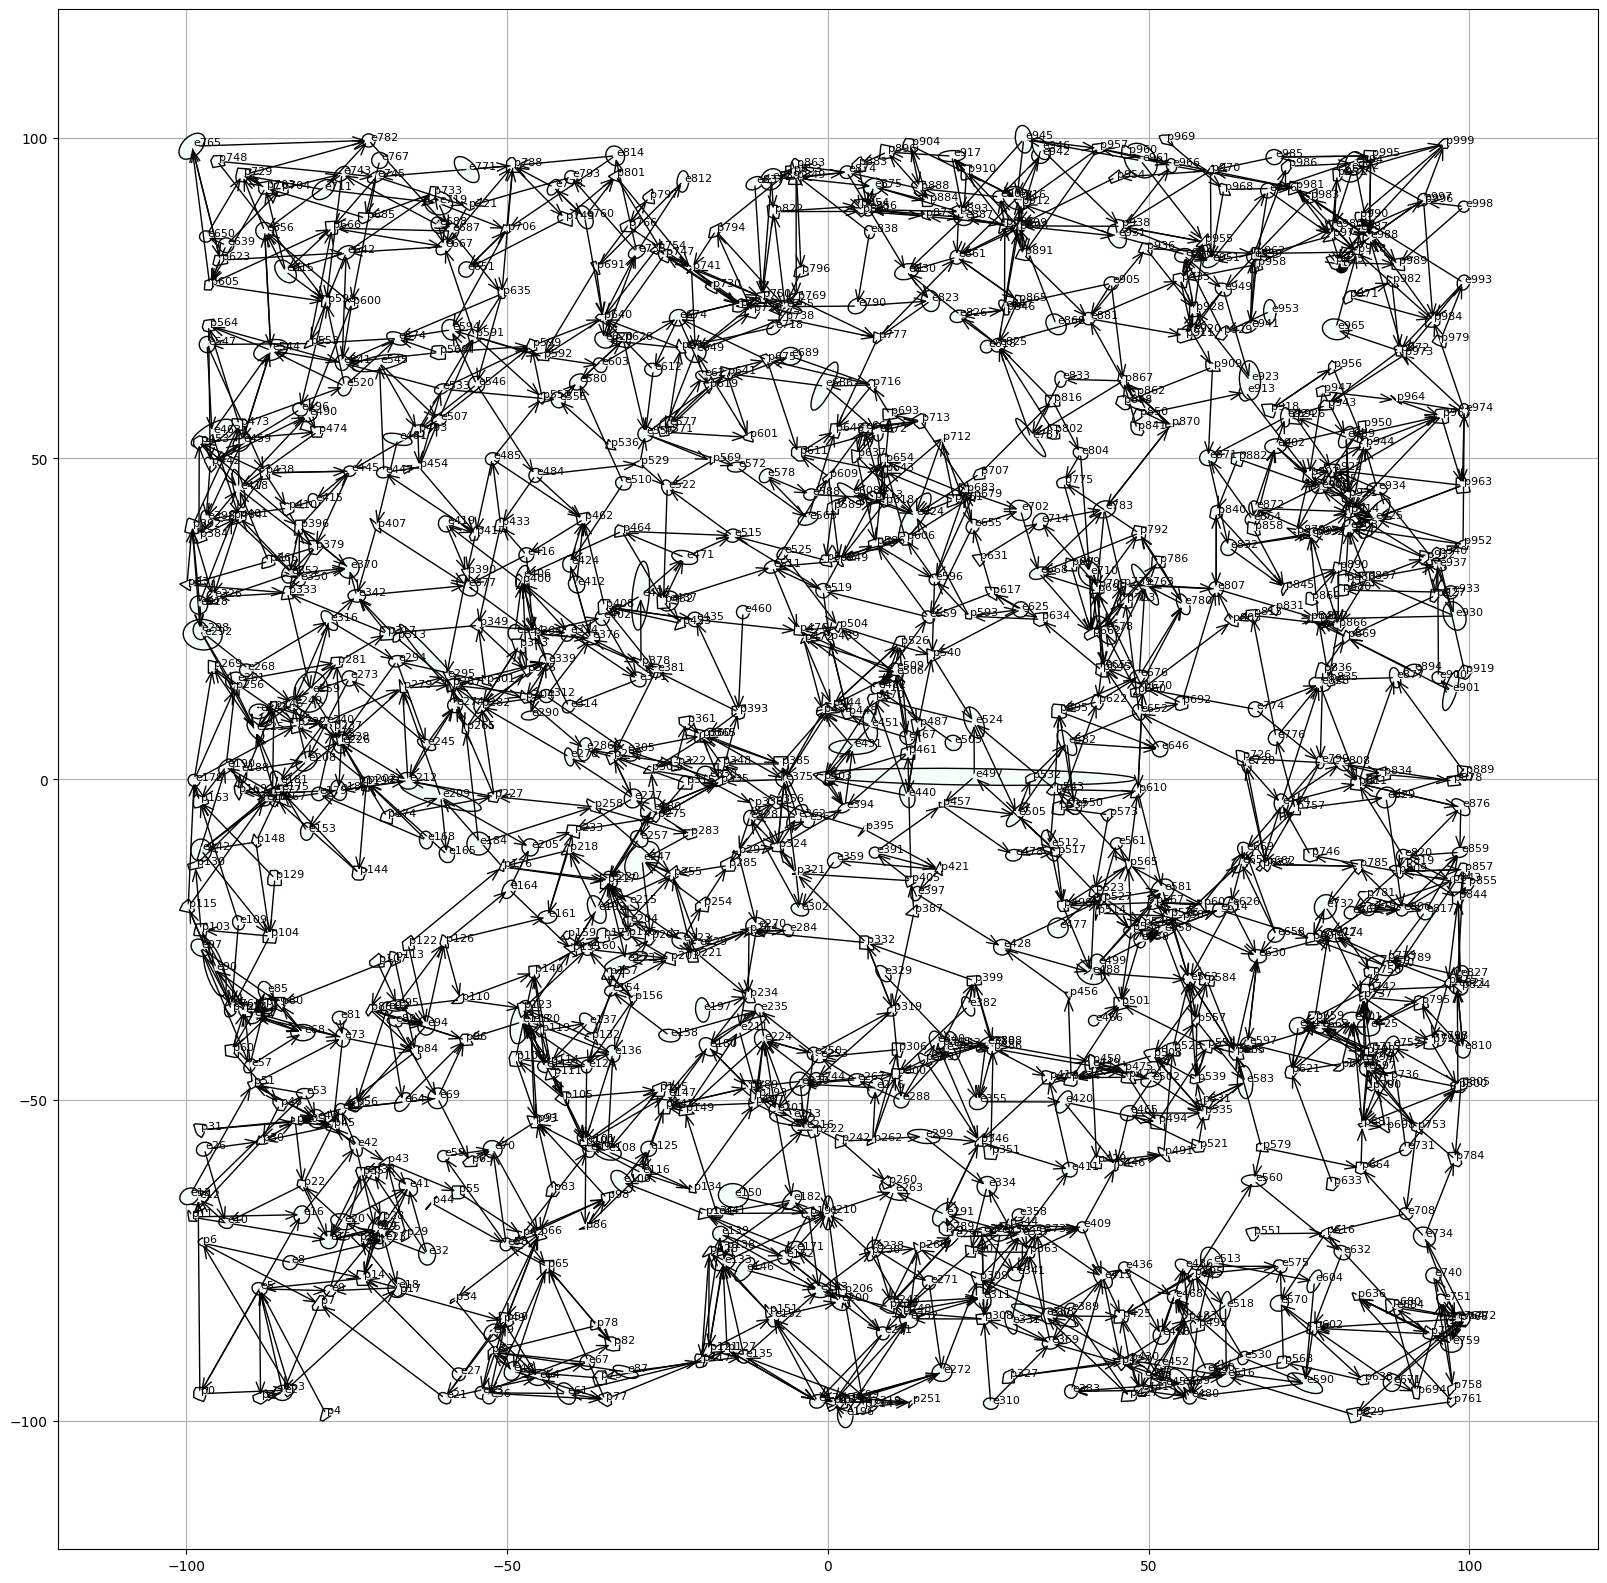

In [5]:
G = generate_spp_shape_gcs(params)

# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
plt.grid()
plt.xlim(G.workspace[0])
plt.ylim(G.workspace[1])
plt.show()

In [6]:
G = load_spp_shape_gcs(graph_file, create_l2norm_edge_cost)
print(G.params)


Adding points as vertices to the graph...


100%|██████████| 2/2 [00:00<00:00, 8012.04it/s]


Adding ellipsoids as vertices to the graph...


100%|██████████| 481/481 [00:00<00:00, 42797.20it/s]


Adding polyhedra as vertices to the graph...


100%|██████████| 519/519 [00:05<00:00, 94.14it/s]


Adding edges to the graph...


100%|██████████| 1001/1001 [00:00<00:00, 10324.09it/s]

GraphParams(dim=2, n_vertices=1002, n_edges=1975, source=array([0., 0.]), target=array([80., 80.]), workspace=array([[-120.,  120.],
       [-120.,  120.]]), default_costs_constraints=DefaultGraphCostsConstraints(vertex_costs=None, vertex_constraints=None, edge_costs=[<pydrake.solvers.L2NormCost object at 0x7f66eb218630>], edge_constraints=None))


## Standard GCS solve on entire graph

In [7]:
sol = G.solve_shortest_path()

For 100V t3, when preprocessing is not enabled, cell above takes 1.9s, and the gcs solve within that is also 1.9s, when it is enabled, then the cell above takes 13.2s, and the gcs solve within that is now faster at 1.7s

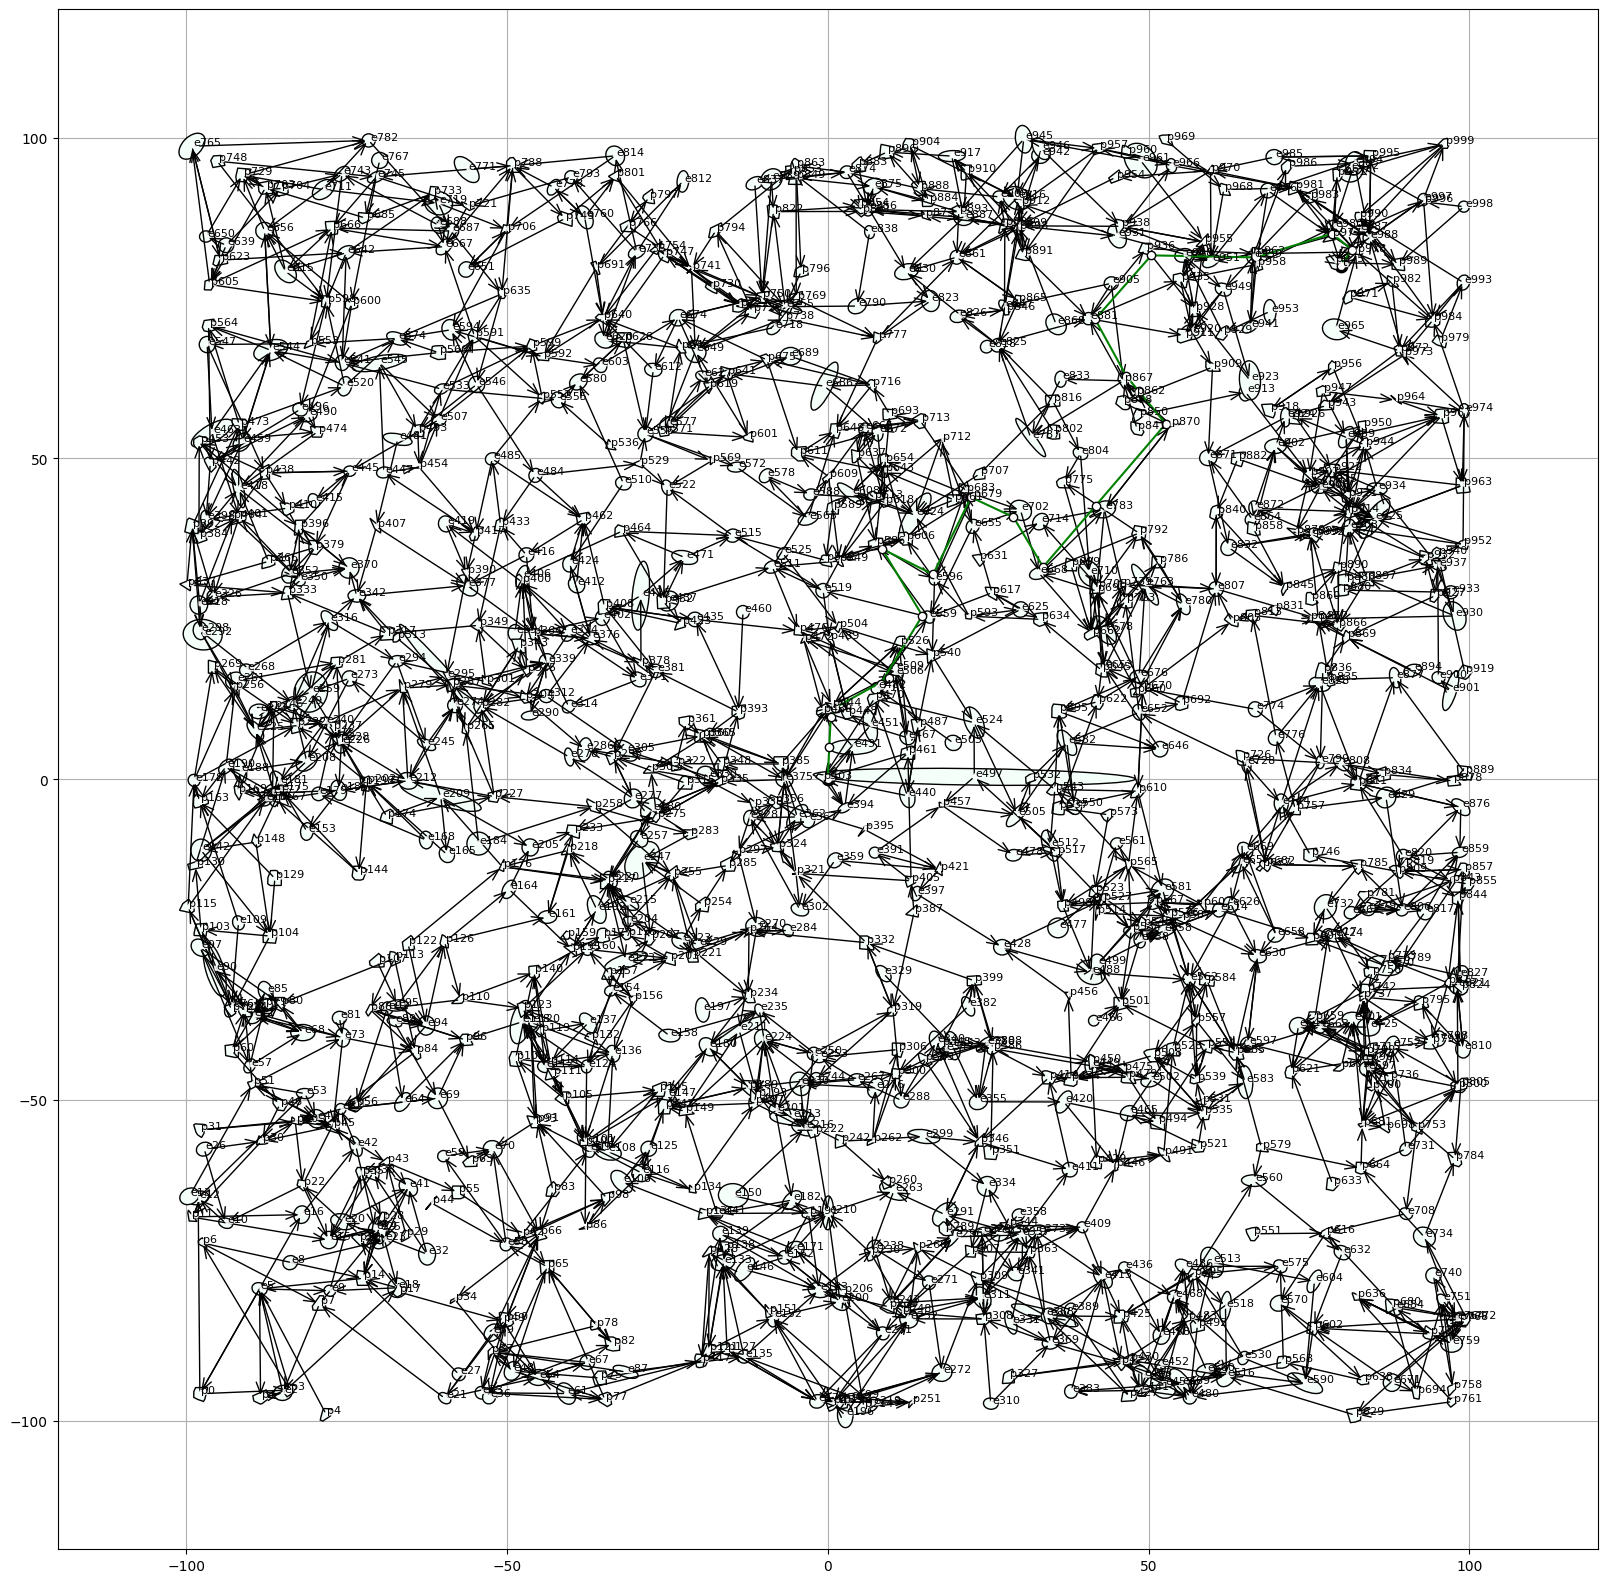

ShortestPathSolution(cost=183.8555045750649, time=3.494932325091213, path=[('s', array([0., 0.])), ('e431', array([0.24223048, 4.99409141])), ('p439', array([0.47, 9.69])), ('p444', array([ 1.19, 11.17])), ('e506', array([ 9.50583181, 15.81229315])), ('e482', array([ 8.22561854, 14.86337796])), ('e559', array([14.74758836, 25.49422097])), ('p586', array([ 8.46      , 35.90999999])), ('e596', array([16.41057498, 31.93093435])), ('p683', array([22.32999999, 43.94999999])), ('e702', array([28.93901813, 40.85975601])), ('e668', array([33.56681202, 33.09195293])), ('e783', array([41.73694837, 42.62276624])), ('p870', array([52.68999999, 55.39999998])), ('p862', array([48.48910376, 60.47121916])), ('p867', array([46.55999999, 62.79999998])), ('e881', array([41.66454783, 71.70572232])), ('p936', array([50.43999999, 81.64999998])), ('p962', array([66.53690337, 81.33321018])), ('p958', array([66.7       , 81.32999998])), ('e980', array([78.59283123, 85.03200016])), ('p978', array([81.66, 82.56]

In [8]:
# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
G.plot_path(sol.path)
plt.grid()
plt.xlim(G.workspace[0])
plt.ylim(G.workspace[1])

plt.show()
print(sol)

## Verifying Params

In [ ]:
data = np.load(graph_file, allow_pickle=True).item()
print(data["params"])

## Running GCS Dijkstra on the graph

In [ ]:
gcs_dijk_vid_file = os.path.join(os.environ['PROJECT_ROOT'], "output", "gcs_dijkstra",
                                 f"gcs_dijkstra_{base_file_name}_l2norm.mp4")

In [ ]:
vis_params = AlgVisParams(vid_output_path=gcs_dijk_vid_file,
                          fps=10,
                          figsize=(20,20),
                        )
gcs_dijk = GcsDijkstra(G, vis_params).run(animate=True)

In [ ]:
Video(gcs_dijk_vid_file)

## Running GCS A* on the graph

In [ ]:
# base_file_name = "spp_2d_v100_t1_shape_gcs"
# graph_file = os.path.join(os.environ['PROJECT_ROOT'], "large_gcs", "example_graphs",
#                     base_file_name + ".npy")
# G = load_spp_shape_gcs(graph_file, create_l2norm_edge_cost)

In [ ]:
gcs_astar_vid_file = os.path.join(os.environ['PROJECT_ROOT'], "output", "gcs_astar",
                                  f"gcs_astar_{base_file_name}_l2norm.mp4")
vis_params = AlgVisParams(vid_output_path=gcs_astar_vid_file,
                          fps=10,
                          figsize=(20,20),
                        )
gcs_astar = GcsAstar(G, vis_params).run(animate=False)

In [ ]:
Video(gcs_astar_vid_file)